# Task 1

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import string
from sklearn.metrics import confusion_matrix

# My custom built Naive Bayes Classifier 
from naive_bayes import NaiveBayesClassifier

# Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

stop_words = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Data Handling 

data = pd.read_csv('car-reviews.csv')

positive_data = data[691:]
negative_data = data[:691]

train_positive = positive_data[:553]
test_positive = positive_data[553:]

train_negative = negative_data[:553]
test_negative = negative_data[553:]

raw_training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
raw_testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)

raw_training_data['Sentiment'] = np.where(raw_training_data['Sentiment'] == 'Pos', 1, 0)
raw_testing_data['Sentiment'] = np.where(raw_testing_data['Sentiment'] == 'Pos', 1, 0)

In [3]:
class Processor():

    def __init__(self):
        self.sentiment_words = None 
        self.vector_sample = []
        self.stemmed_sample = []
        self.non_stemmed_sample = []

    
    def pre_processing(self, sentiment, review):
        words = review.split()
        stemmed_words = []
        stemmed_sample = {'Sentiment': sentiment,
                  'Word Table': {} }
        non_stemmed_sample = {'Sentiment': sentiment,
                              'Word Table': {} }
    
        # Loop through all words in sample 
        for word in words:

            # Remove cappital sensitivity 
            word = word.lower()

            # Removes all punctuation 
            word = ''.join(char for char in word if char not in string.punctuation)

            # Remove numbers and filter out stop words 
            if word not in stop_words:
                try:
                    int(word)
                    continue
                except:
                    pass

                try:
                    non_stemmed_sample['Word Table'][word] = non_stemmed_sample['Word Table'][word] + 1 
                except:
                    non_stemmed_sample['Word Table'][word] = 0
        
                # Applies the Snoball Stemmer from the NLTK package to the list of words in the sample 
                stemmed_word = snowball_stemmer.stem(word)
                stemmed_words.append(stemmed_word)
    
        # Create word count table of filtered stemmed words 
        for stemmed_word in stemmed_words:
            try:
                stemmed_sample['Word Table'][stemmed_word] = stemmed_sample['Word Table'][stemmed_word] + 1 
            except:
                stemmed_sample['Word Table'][stemmed_word] = 0

        self.stemmed_sample.append(stemmed_sample)
        self.non_stemmed_sample.append(non_stemmed_sample)

        return stemmed_sample



    
    def word_processing(self, training_data, testing):
        processed_samples = []
        all_words = None
    
        # Run each sample though pre-processing to filter and stem the words. Table returned
        for index, row in training_data.iterrows():
            sentiment = row['Sentiment']
            review = row['Review']
            sample = self.pre_processing(sentiment, review)
            processed_samples.append(sample)  

            # Create a sample to demonstrate the code logic in categorising and counting words per sample 
            if index in [0, (len(training_data) // 2), (len(training_data) - 1)] and not testing:
                self.vector_sample.append(training_data['Review'].iloc[index])

        # Itterate through each processed sample and add new words the all_words list 
        for idx, sample in enumerate(processed_samples):
            words = list(sample['Word Table'].keys())
            
            if idx == 0:
                all_words = words
            else:
                for word in words:
                    if word not in all_words:
                        all_words.append(word)

        return all_words, processed_samples



    
    def sentiment_filter(self, all_words):
        
        # Initialise the sentiment intensity analyser
        sia = SentimentIntensityAnalyzer()
        sentiment_words = []
        
        for word in all_words:
            # Find the sentiment intensity score of the word
            score = sia.polarity_scores(word)['compound']
            
            # Filter words based on sentiment being over or under 0. 0 being a neutral word
            if score != 0:
                sentiment_words.append(word)

        return sentiment_words

    
    
    
    def process_binary_data(self, processed_samples):
        all_data = []
        sample_data = []
        sample_count = 0

        # Convert word data to binary lists. First element is the label, the rest are the features 
        for sample in processed_samples:
            sentiment = sample['Sentiment']
            sample_data.append(sentiment)

            '''
            This logic below transforms the processed sample data into a binary format, which is vital for machine learning models to learn from.

            The sentiment of each sample is encoded at the start of its binary list (1 for 'Pos', 0 for all others), this is the label for supervised learning. 
            Then for each sample, a binary feature vector is generated. Each element in this vector signals whether a word from the list of sentiment-relevant words 
            (self.sentiment_words) is present (1) or absent (0) in the sample.

            The reason for selecting this approach is due to the consistency in feature vector length. This ensures uniformity in the length of feature vectors across 
            samples, this is vital for efficient model training and evaluation. A consistent vector size eliminates the need for adjustments based on individual sample
            content. This approach also simplifies error handling, by assigning absent words a '0' in the feature vector, the method avoids potential errors due to missing
            keys. This approach also utilises Python's handling of non-existent dictionary keys, which naturally avoids raising errors for such cases. As a result, this 
            eliminates the necessity for explicit error handling constructs like try-except blocks, reducing code complexity and improving readability. 
            This design also enhances the robustness and maintainability of the code by relying on Python's inherent features.
            '''
            
            for word in self.sentiment_words:
                if word in list(sample['Word Table'].keys()):
                    sample_data.append(1)
                else:
                    sample_data.append(0)
                    
            all_data.append(sample_data) 
            sample_data = []
    
        return np.array(all_data)


    
    
    def process(self, raw_data, testing=False):
        # Controller function that passes the raw text data to pre-processing and filters the word table for non-neutral words and outputs a binary data table for learning
        
        all_words, processed_samples = self.word_processing(raw_data, testing)

        if testing == False:
            self.sentiment_words = self.sentiment_filter(all_words)
            
        binary_data = self.process_binary_data(processed_samples)
        
        return binary_data

    
    
    def get_vector_samples(self):
        # 3 selected examples of my code outputting a word table during pre-processing 
        
        print(f'**********************  Vector Samples  **********************')
        print('\n')
        for sample in self.vector_sample:
            json_str = json.dumps(sample, indent=2)
            flattened_str = json_str.replace('\n', ' ').replace('  ', '')
            print(flattened_str)
            print('\n')


    
    def get_stemmed_samples(self):
        # 5 selected examples of my code stemming words during pre-processing 
        
        example_count = 0
        stemmed_sample_data = [{'Index': 0,
                               'Stemmed Word': 'work'},
                               {'Index': 25,
                               'Stemmed Word': 'cost'},
                               {'Index': 42,
                               'Stemmed Word': 'comfort'},
                               {'Index': 97,
                               'Stemmed Word': 'replace'},
                               {'Index': 105,
                               'Stemmed Word': 'handl'}]

        print(f'**********************  Stemmed Samples  **********************')
        print('\n')
        
        for stemmed_data in stemmed_sample_data:
        
            example_count += 1
            print(f'Stemmed Sample {example_count}')
            print('\n')
            index = stemmed_data['Index']
            word = stemmed_data['Stemmed Word']
        
            print('Training Data Index: ', index)
            print('Stemmed Word: ', word)
            print('\n')
        
            for sample in self.non_stemmed_sample[index]['Word Table']:
                if word in sample:        
                    count = self.non_stemmed_sample[index]['Word Table'][sample]
                    print('Pre-Stemmed Word: ', sample)
                    
            print('\n')
            print('Pre-Stemmed Word Table:')
            print('\n')
            print(self.non_stemmed_sample[index]['Word Table'])
            print('\n')
            print('Stemmed Word Table:')
            print('\n')
            print(self.stemmed_sample[index]['Word Table'])
            print('\n')
            print('\n')
            print('\n')

In [4]:
def process_data(processor):
    
    training_data = processor.process(raw_training_data, testing=False)
    testing_data = processor.process(raw_testing_data, testing=True)
    
    return training_data, testing_data



def custom_bayes(training_data, testing_data):
    
    naive_bayes = NaiveBayesClassifier(training_data, testing_data)
    predictions = naive_bayes.run()

    conf_matrix = confusion_matrix(testing_data[:, 0], predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    display(conf_matrix_df)
    print('\n')
    
    accuracy = np.sum(predictions == testing_data[:, 0]) / len(testing_data[:, 0])
    print(f"Accuracy: {round(accuracy, 3)}")
    print('\n')



def show_samples(processor):
    
    processor.get_vector_samples()
    processor.get_stemmed_samples()



processor = Processor()
training_data, testing_data = process_data(processor)
custom_bayes(training_data, testing_data)
show_samples(processor)

,Predicted Negative,Predicted Positive
Actual Negative,115,23
Actual Positive,47,91




Accuracy: 0.746




# Task 2

In [10]:
# Visualisation 
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score

# Keras for deep learning models
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenising text data
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For sequence padding to uniform length
from tensorflow.keras.models import Sequential  # For sequential model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout  # Layers for model building
from tensorflow.keras.regularizers import l2  # L2 regularisation to prevent overfitting

In [11]:
def prepare_data():
    
    # Load the dataset from a CSV file
    data = pd.read_csv('car-reviews.csv')
    
    # Splitting the data into positive and negative reviews based on a predetermined index
    positive_data = data[691:]  
    negative_data = data[:691]  
    
    # Further split positive and negative datasets into training and testing subsets
    train_positive = positive_data[:553]
    test_positive = positive_data[553:] 
    train_negative = negative_data[:553]
    test_negative = negative_data[553:]  
    
    # Concatenate the positive and negative training data, and do the same for testing data
    training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
    testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)
    
    # Convert the 'Sentiment' column into a binary format: 1 for positive, 0 for negative
    training_data['Sentiment'] = np.where(training_data['Sentiment'] == 'Pos', 1, 0)
    testing_data['Sentiment'] = np.where(testing_data['Sentiment'] == 'Pos', 1, 0)

    # Extract reviews (as text) and their corresponding labels for training and testing
    training_texts = list(training_data['Review'])
    training_labels = list(training_data['Sentiment'])
    test_texts = list(testing_data['Review'])
    test_labels = list(testing_data['Sentiment'])

    # Return the processed text and labels for training and testing
    return training_texts, training_labels, test_texts, test_labels

In [12]:
def tokenisation():
    
    training_texts, training_labels, test_texts, test_labels = prepare_data()
    
    # Initialise the tokenizer with a maximum number of words to keep, based on word frequency
    tokenizer = Tokenizer(num_words=10000)  # Setting the size of the vocabulary to the top 10,000 words
    tokenizer.fit_on_texts(training_texts)  # Updates internal vocabulary based on the list of texts
    
    # Convert the list of texts to a sequence of integers
    train_sequences = tokenizer.texts_to_sequences(training_texts)  # Transforms each text in training_texts to a sequence of integers
    train_data = pad_sequences(train_sequences, maxlen=100)  # Ensures all sequences in a list have the same length by padding/truncating
    train_labels = np.array(training_labels)  
    
    # Repeat the tokenisation and padding process for the testing set
    test_sequences = tokenizer.texts_to_sequences(test_texts) 
    test_data = pad_sequences(test_sequences, maxlen=100) 
    test_labels = np.array(test_labels)  

    return train_data, train_labels, test_data, test_labels

In [13]:
def LTSM_model(train_data, train_labels, test_data, test_labels, embedding_dim, lstm_unit, dropout_rate, reg_strength):
    
    """
    Parameters:
        - embedding_dim: Dimension of the embedding layer
        - lstm_unit: Number of units in the LSTM layer
        - dropout_rate: Dropout rate for regularization
        - reg_strength: Strength of L2 regularization
    """

    model = Sequential([
        
        # Input layer specifies the shape of input data (100 set = sequence length)
        Input(shape=(100,)),
        
        # Embedding layer to turn positive integers (indexes) into dense vectors of fixed size, 10000 is the size of the vocabulary
        Embedding(input_dim=10000, output_dim=embedding_dim),
        
        # LSTM layer with specified units and dropout for regularization
        LSTM(lstm_unit, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        
        # Dense output layer with sigmoid activation for binary classification
        Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_strength))
    ])
    
    # Compile the model with Adam optimizer and binary crossentropy loss, tracking accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the training data, with a validation split to monitor overfitting
    history = model.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split=0.2)

    # Predict probabilities on the test set and convert to class labels (1 or 0) based on a 0.5 threshold
    test_predictions_proba = model.predict(test_data)
    test_predictions = (test_predictions_proba > 0.5).astype("int32").flatten()
    
    # Generating the confusion matrix from test labels and predictions
    conf_matrix = confusion_matrix(test_labels, test_predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print('\n')
    display(conf_matrix_df)

    accuracy = accuracy_score(test_labels, test_predictions)
    print('\n')
    print('Accuracy: ', round(accuracy, 3))
    print('\n')

    # Call the model evaluation function to plot training history
    model_evaluation(history)

In [14]:
def model_evaluation(history):
    
    # Training history data
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs = range(1, len(training_accuracy) + 1)
    
    plt.figure(figsize=(10, 4))
    
    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6183 - loss: 1.3044 - val_accuracy: 0.0000e+00 - val_loss: 1.4074
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6315 - loss: 1.1180 - val_accuracy: 0.0045 - val_loss: 1.3437
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7051 - loss: 0.9127 - val_accuracy: 0.5631 - val_loss: 1.0444
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8956 - loss: 0.6910 - val_accuracy: 0.5225 - val_loss: 1.1920
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9029 - loss: 0.5511 - val_accuracy: 0.4685 - val_loss: 1.2799
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9531 - loss: 0.4634 - val_accuracy: 0.5495 - val_loss: 1.1110
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9504 - loss: 0.4725 - val_accuracy: 0.6036 - val_loss: 1.0396
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9646 - loss: 0.3903 - val_accuracy: 0.6847

,Predicted Negative,Predicted Positive
Actual Negative,69,69
Actual Positive,28,110




Accuracy:  0.649




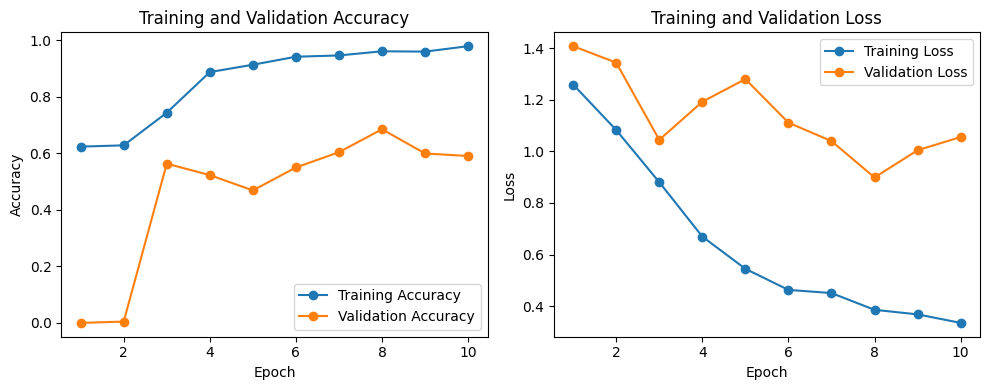

In [15]:
# Process the data and run the model 
train_data, train_labels, test_data, test_labels = tokenisation()
LTSM_model(train_data, train_labels, test_data, test_labels, embedding_dim = 62, lstm_unit = 48, dropout_rate = 0.2, reg_strength = 0.3)